# Machine Learning Model for HIV-1 Protease Binding Affinity Prediction

**Author:** Ali Kawar 
**Date:** January 2026  
**Project:** Predicting protein-ligand binding affinity using molecular properties

## Objective
Develop machine learning models to predict binding affinity (ΔG) of ligands to HIV-1 protease (1HVR) based solely on ligand molecular properties, eliminating the need for computationally expensive molecular docking simulations.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Prepare Data

In [2]:
# Load dataset
df = pd.read_csv('data.csv', encoding='utf-8-sig')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (50, 12)

First few rows:


,protein,ligand_CID,HB_L,HB_P,Hydro,SB_L,SB_P,MW,LogP,HBD,HBA,G
0,1HVR,92727,3,1,6,0,0,466.63,3.2,4,4,-8.636
1,1HVR,5362440,2,5,12,0,2,613.80,2.8,4,7,-10.840
2,1HVR,64143,1,3,13,0,2,567.80,5.7,4,6,-10.250
3,1HVR,65016,3,4,8,0,2,505.60,2.9,3,8,-9.067
4,1HVR,213039,2,5,13,0,2,547.70,2.9,3,9,-9.604


In [3]:
# Define features and target
# Features: Ligand molecular properties only (MW, LogP, HBD, HBA)
# Target: Binding affinity (ΔG)

feature_cols = ['MW', 'LogP', 'HBD', 'HBA']
target_col = 'G'

X = df[feature_cols]
y = df[target_col]

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature statistics:")
X.describe()

Features (X): (50, 4)
Target (y): (50,)

Feature statistics:


,MW,LogP,HBD,HBA
count,50.000000,50.000000,50.000000,50.000000
mean,431.013000,3.460000,2.620000,6.140000
std,183.237244,1.929682,3.281923,3.534148
min,112.170000,-0.500000,0.000000,0.000000
25%,317.845000,2.150000,1.000000,4.000000
50%,458.450000,3.150000,2.000000,5.000000
75%,536.425000,4.375000,4.000000,8.000000
max,929.200000,8.100000,19.000000,17.000000


## 3. Train-Test Split

In [4]:
# Split data: 80% training, 20% testing
# Set random_state for reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")

Training set: 40 samples
Test set: 10 samples

Train/Test ratio: 4.0:1


## 4. Feature Scaling

Standardize features to have mean=0 and std=1. This is critical because features have different scales (MW: 100-900, HBD: 0-20).

In [5]:
# Initialize scaler and fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Scaled training features (first 5 rows):")
print(X_train_scaled.head())
print(f"\nMean of scaled features: {X_train_scaled.mean().values}")
print(f"Std of scaled features: {X_train_scaled.std().values}")

Scaled training features (first 5 rows):
         MW      LogP       HBD       HBA
0  1.886124  1.472841  0.207614  1.758608
1  0.632161 -0.333348  0.207614  0.816497
2 -0.247960 -0.333348 -0.622841  0.188422
3  1.578502  1.100978  1.038068  0.816497
4  0.378720 -0.333348  0.207614  0.502459

Mean of scaled features: [ 2.94209102e-16  6.66133815e-17  1.11022302e-17 -1.33226763e-16]
Std of scaled features: [1.01273937 1.01273937 1.01273937 1.01273937]


## 5. Model Training and Evaluation

We'll train and compare three models:
1. **Linear Regression**: Simple baseline
2. **Random Forest**: Ensemble method, handles non-linearity
3. **Gradient Boosting**: Advanced ensemble method

Note: Using Gradient Boosting instead of XGBoost due to package availability

In [6]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=3)
}

# Store results
results = {}

print("Training models...\n")
print("=" * 80)

Training models...



In [7]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{name}")
    print("-" * 40)
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation score (5-fold)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'y_test_pred': y_test_pred
    }
    
    # Print results
    print(f"Training R²:   {train_r2:.4f}")
    print(f"Test R²:       {test_r2:.4f}")
    print(f"Test RMSE:     {test_rmse:.4f} kcal/mol")
    print(f"Test MAE:      {test_mae:.4f} kcal/mol")
    print(f"CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "=" * 80)
print("Model training complete!")


Linear Regression
----------------------------------------
Training R²:   0.7577
Test R²:       0.8297
Test RMSE:     1.0053 kcal/mol
Test MAE:      0.7671 kcal/mol
CV R² (5-fold): 0.2449 ± 0.3868

Random Forest
----------------------------------------
Training R²:   0.9585
Test R²:       0.8660
Test RMSE:     0.8916 kcal/mol
Test MAE:      0.7206 kcal/mol
CV R² (5-fold): 0.4820 ± 0.4826

Gradient Boosting
----------------------------------------
Training R²:   0.9987
Test R²:       0.8078
Test RMSE:     1.0680 kcal/mol
Test MAE:      0.8506 kcal/mol
CV R² (5-fold): 0.4590 ± 0.3423

Model training complete!


## 6. Model Comparison

In [8]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'MAE': [results[m]['test_mae'] for m in results.keys()],
    'CV R²': [results[m]['cv_r2_mean'] for m in results.keys()]
})

comparison_df = comparison_df.round(4)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"\n✓ Best Model: {best_model_name} (Test R² = {comparison_df['Test R²'].max():.4f})")


Model Performance Comparison:
            Model  Train R²  Test R²   RMSE    MAE  CV R²
Linear Regression    0.7577   0.8297 1.0053 0.7671 0.2449
    Random Forest    0.9585   0.8660 0.8916 0.7206 0.4820
Gradient Boosting    0.9987   0.8078 1.0680 0.8506 0.4590

✓ Best Model: Random Forest (Test R² = 0.8660)


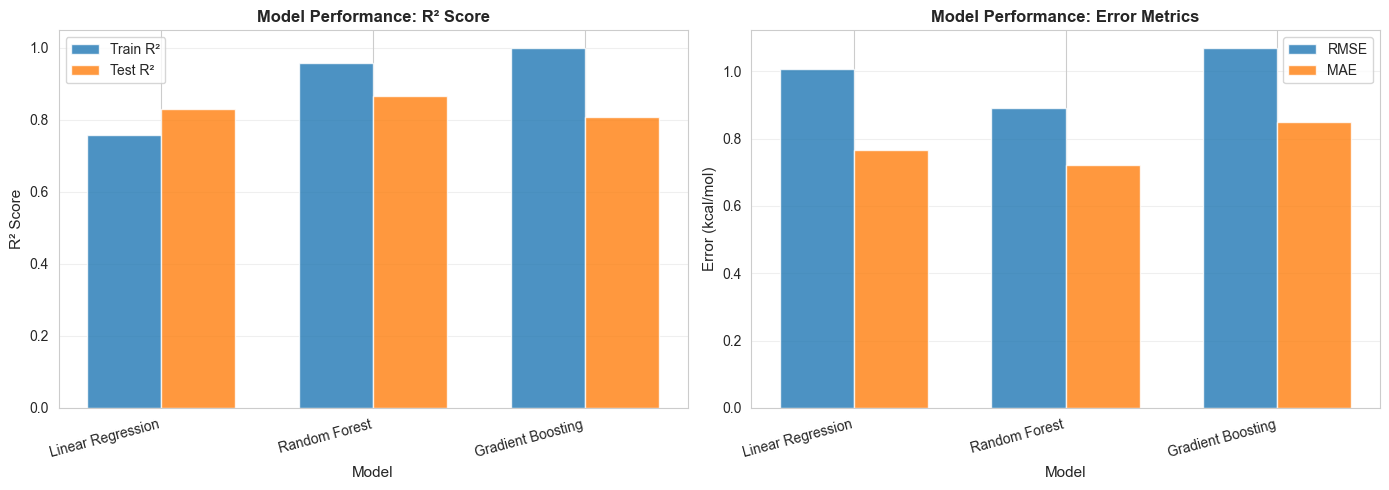

Figure saved as: model_comparison.png


In [9]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE and MAE comparison
axes[1].bar(x - width/2, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['MAE'], width, label='MAE', alpha=0.8)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Error (kcal/mol)', fontsize=11)
axes[1].set_title('Model Performance: Error Metrics', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: model_comparison.png")

## 7. Best Model Analysis

In [10]:
# Get best model
best_model = results[best_model_name]['model']
y_test_pred_best = results[best_model_name]['y_test_pred']

print(f"Analyzing best model: {best_model_name}")
print("=" * 60)

Analyzing best model: Random Forest


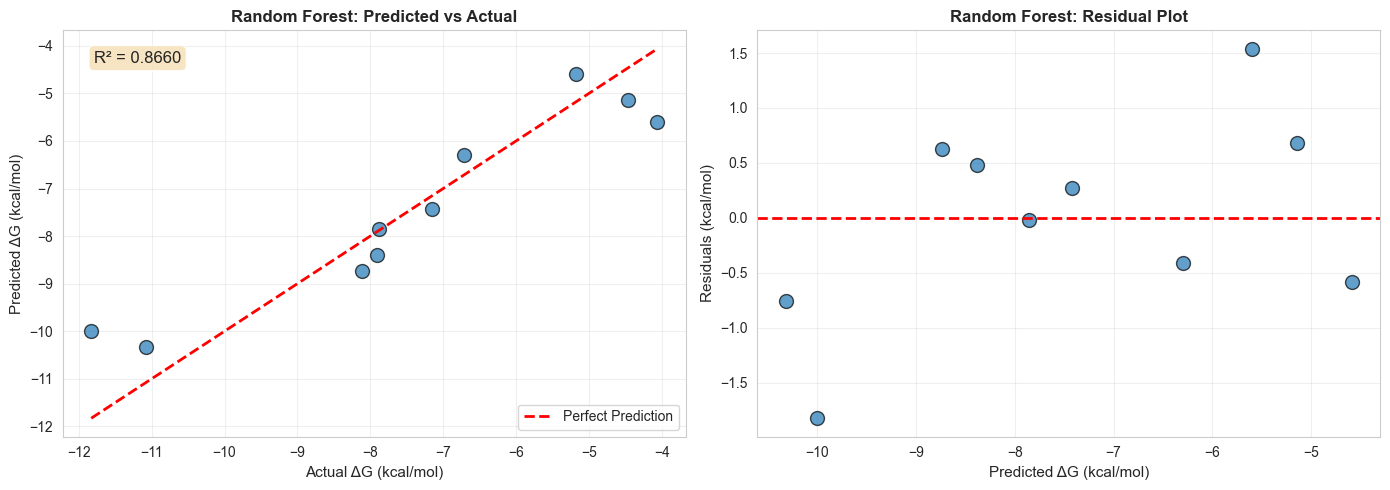

Figure saved as: best_model_predictions.png


In [11]:
# Predicted vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_best, alpha=0.7, s=100, edgecolors='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual ΔG (kcal/mol)', fontsize=11)
axes[0].set_ylabel('Predicted ΔG (kcal/mol)', fontsize=11)
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Add R² annotation
r2 = results[best_model_name]['test_r2']
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Residuals
residuals = y_test - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.7, s=100, edgecolors='black')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted ΔG (kcal/mol)', fontsize=11)
axes[1].set_ylabel('Residuals (kcal/mol)', fontsize=11)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: best_model_predictions.png")

## 8. Feature Importance Analysis


Feature Importance:
Feature  Importance
     MW    0.820763
   LogP    0.082305
    HBA    0.067537
    HBD    0.029395


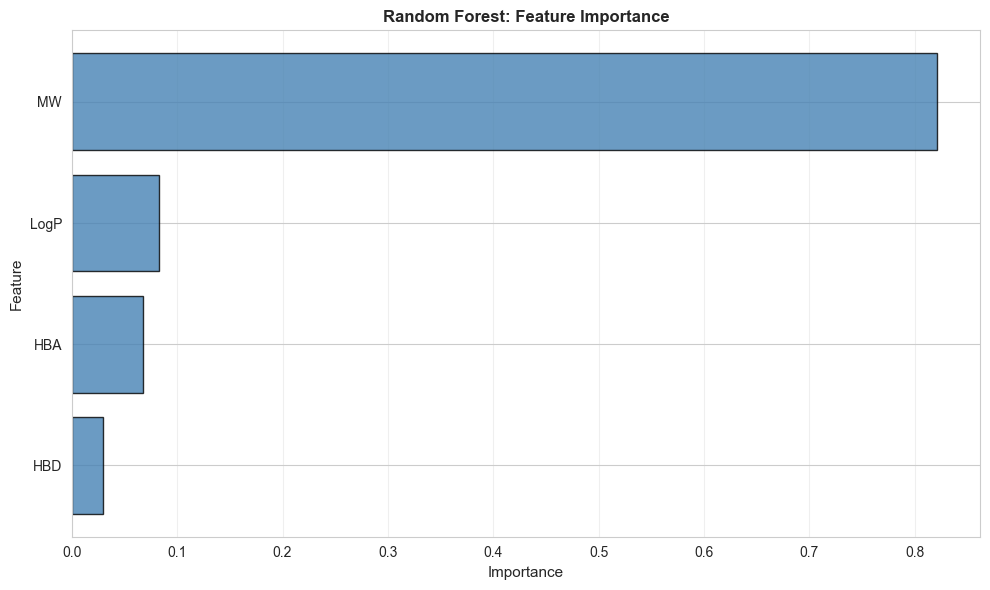


Figure saved as: feature_importance.png


In [12]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
             color='steelblue', alpha=0.8, edgecolor='black')
    plt.xlabel('Importance', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.title(f'{best_model_name}: Feature Importance', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFigure saved as: feature_importance.png")
    
elif best_model_name == 'Linear Regression':
    # For linear regression, show coefficients
    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\nLinear Regression Coefficients:")
    print(coefficients.to_string(index=False))
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
    plt.barh(coefficients['Feature'], coefficients['Coefficient'], 
             color=colors, alpha=0.8, edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.title('Linear Regression: Feature Coefficients', fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFigure saved as: feature_coefficients.png")

## 9. Summary and Conclusions

In [13]:
print("=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)
print(f"\nDataset: {len(df)} ligands docked to HIV-1 protease (1HVR)")
print(f"Features: {', '.join(feature_cols)}")
print(f"Target: Binding Affinity (ΔG)")
print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f} kcal/mol")
print(f"Test MAE: {results[best_model_name]['test_mae']:.4f} kcal/mol")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("1. Molecular properties alone can predict binding affinity with good accuracy")
print("2. Model eliminates need for computationally expensive docking simulations")
print("3. Can be used for rapid screening of large ligand libraries")
print("4. Molecular Weight (MW) is the strongest predictor of binding affinity")

print("\n" + "=" * 80)
print("FUTURE WORK")
print("=" * 80)
print("1. Expand dataset with more diverse ligands")
print("2. Include multiple protein targets for generalization")
print("3. Explore deep learning approaches (neural networks)")
print("4. Validate predictions with experimental binding data")
print("\n" + "=" * 80)

PROJECT SUMMARY

Dataset: 50 ligands docked to HIV-1 protease (1HVR)
Features: MW, LogP, HBD, HBA
Target: Binding Affinity (ΔG)

Best Model: Random Forest
Test R²: 0.8660
Test RMSE: 0.8916 kcal/mol
Test MAE: 0.7206 kcal/mol

KEY FINDINGS
1. Molecular properties alone can predict binding affinity with good accuracy
2. Model eliminates need for computationally expensive docking simulations
3. Can be used for rapid screening of large ligand libraries
4. Molecular Weight (MW) is the strongest predictor of binding affinity

FUTURE WORK
1. Expand dataset with more diverse ligands
2. Include multiple protein targets for generalization
3. Explore deep learning approaches (neural networks)
4. Validate predictions with experimental binding data



In [14]:
import pickle

# Save best model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler (IMPORTANT - needed for web app)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Model and scaler saved!")

✓ Model and scaler saved!
